[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Как обучить YOLOv12 на своем датасете

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)


[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) - это новый вариант семейства YOLO, ориентированный на внимание, который фокусируется на включении эффективных механизмов внимания в основу при сохранении производительности в реальном времени. Вместо того чтобы в значительной степени полагаться на архитектуру на основе CNN, как это было у предшественников, YOLOv12 вводит простой, но мощный модуль «внимание к области», который стратегически разделяет карту признаков, чтобы уменьшить квадратичную сложность полного самовнимания. В ней также используются сети агрегации слоев с эффективным остатком (R-ELAN) для повышения эффективности агрегации признаков и стабильности обучения, особенно для больших моделей. Эти инновации, а также такие усовершенствования, как масштабирование остаточных связей и уменьшение коэффициента MLP, позволяют YOLOv12 использовать преимущества внимания (например, лучшее моделирование глобального контекста) без ущерба для скорости.


![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

По сравнению с предыдущими итерациями YOLO (например, YOLOv10, YOLOv11 и YOLOv8), YOLOv12 достигает более высокой точности обнаружения при конкурентном или более быстром времени вывода во всех масштабах модели. Пять размеров модели - N, S, M, L и X - варьируются от 2,6 до 59,1 млн параметров, что обеспечивает сильный баланс между точностью и скоростью. Например, самая маленькая модель YOLOv12-N превосходит другие «нано» модели более чем на 1% mAP при задержке около 1,6 мс на GPU T4, а самая большая YOLOv12-X достигает 55,2% mAP, значительно превосходя сравнимые детекторы реального времени, такие как RT-DETR и YOLOv11-X. Соответствуя или превосходя современную точность и оставаясь при этом быстрым, YOLOv12 представляет собой заметный шаг вперед для обнаружения объектов в реальном времени на основе внимания.


![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Настройка среды

### Проверьте доступность GPU

**ПРИМЕЧАНИЕ:** **YOLOv12 использует FlashAttention для ускорения вычислений, основанных на внимании, но для этой функции требуется GPU Nvidia, построенный на архитектуре Ampere или более новой - например, такие GPU, как RTX 3090, RTX 3080 или даже Nvidia L4, соответствуют этому требованию**.

Давайте убедимся, что у нас есть доступ к GPU. Для этого мы можем использовать команду `nvidia-smi`. В случае возникновения проблем перейдите в `Edit` -&gt; `Настройки ноутбука` -&gt; `Аппаратный ускоритель`, установите значение `GPU`, а затем нажмите `Сохранить`.

In [ ]:
!nvidia-smi

Mon Apr 28 14:08:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Установите зависимости

**ПРИМЕЧАНИЕ:** В настоящее время YOLOv12 не имеет собственного пакета PyPI, поэтому мы устанавливаем его прямо с GitHub, добавляя при этом roboflow (для удобного получения наборов данных из вселенной Roboflow), supervision (для визуализации результатов выводов и бенчмарков производительности модели) и flash-attn (для ускорения вычислений на основе внимания с помощью оптимизированных ядер CUDA).

In [2]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Скачать пример данных

Давайте загрузим изображение, которое мы можем использовать для вывода YOLOv12. Не стесняйтесь перетаскивать свои собственные изображения на вкладку «Файлы» в левой части Google Colab, а затем ссылаться на их имена файлов в своем коде для демонстрации пользовательских выводов.

In [3]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-04-30 18:38:19--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-04-30 18:38:19 (123 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

В примере мы используем модель `yolov12l.pt`, но вы можете экспериментировать с разными размерами модели, просто меняя название модели при инициализации. Варианты включают `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt` и `yolov12x.pt`.

100%|██████████| 88.1M/88.1M [00:02<00:00, 40.6MB/s]


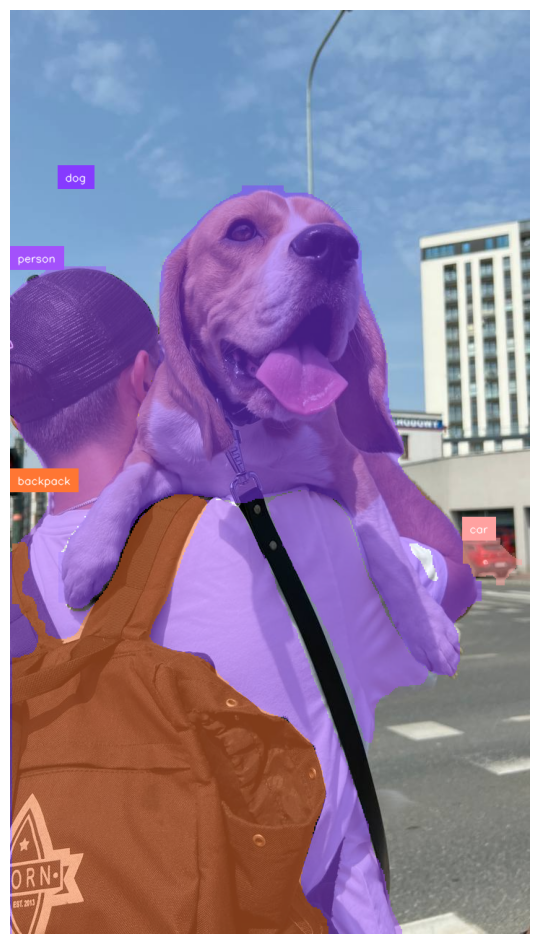

In [ ]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov8l-seg.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

mask_annotator = sv.MaskAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = mask_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [4]:
import zipfile
with zipfile.ZipFile('/content/Body Parts.v1i.yolov8.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')

In [5]:
!ls '/content/datasets'

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**ПРИМЕЧАНИЕ:** Нам нужно внести несколько изменений в наш загруженный набор данных, чтобы он работал с YOLOv12. Выполните следующие команды bash, чтобы подготовить набор данных к обучению, обновив относительные пути в файле `data.yaml`, чтобы они правильно указывали на подкаталоги для подмножеств `train`, `test` и `valid` вашего набора данных.

In [6]:
dataset_location = '/content/datasets'

## Тонкая настройка модели YOLOv8-seg

Теперь мы готовы к тонкой настройке нашей модели YOLOv8. В приведенном ниже коде мы инициализируем модель с помощью начальной контрольной точки - здесь мы используем `yolov8m-seg.pt`, но вы можете заменить ее на любую другую модель, исходя из ваших предпочтений. В данном примере мы задали 100 эпох обучения, однако вы должны настроить количество эпох, а также другие гиперпараметры, такие как размер партии, размер изображения и параметры дополнения (масштаб, мозаика, смешивание и копирование-вставка), исходя из возможностей вашего оборудования и размера набора данных.

**Примечание:** ** Обратите внимание, что после обучения вы можете столкнуться с ошибкой `TypeError: argument of type „PosixPath“ is not iterable error` - это известная проблема, но веса вашей модели будут сохранены, и вы сможете спокойно перейти к выполнению вычислений.**

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8m-seg.pt')

results = model.train(data=f'{dataset_location}/data.yaml', epochs=20)

FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
New https://pypi.org/project/ultralytics/8.3.119 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=/content/datasets/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augmen

train: Scanning /content/datasets/train/labels.cache... 503 images, 0 backgrounds, 0 corrupt: 100%|██████████| 503/503 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1853: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/datasets/valid/labels.cache... 160 images, 1 backgrounds, 0 corrupt: 100%|██████████| 160/160 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0005, momentum=0.9) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/20      8.16G      1.004      2.993      2.645      1.347         93        640: 100%|██████████| 32/32 [00:26<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]

                   all        160       1071       0.46      0.499       0.45      0.299      0.413      0.478      0.401      0.247



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.32G     0.8841      2.132      1.452      1.221         53        640: 100%|██████████| 32/32 [00:24<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]

                   all        160       1071      0.525      0.562      0.569      0.368      0.507      0.532      0.527      0.325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.35G      0.876      1.998      1.275      1.206        106        640: 100%|██████████| 32/32 [00:23<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        160       1071      0.552      0.615      0.573       0.38      0.519      0.575      0.524      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.57G     0.8444      1.902      1.159       1.19         91        640: 100%|██████████| 32/32 [00:23<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

                   all        160       1071      0.512      0.586      0.547      0.353      0.491      0.542      0.496      0.317



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.77G     0.8167      1.822      1.093      1.174         67        640: 100%|██████████| 32/32 [00:23<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]

                   all        160       1071      0.557      0.573      0.577      0.383      0.527      0.537      0.531      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.54G     0.7798      1.734      1.016      1.133         63        640: 100%|██████████| 32/32 [00:23<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        160       1071      0.588      0.616      0.607      0.416      0.559       0.58      0.558      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/20       8.5G     0.7781        1.7     0.9518      1.128         70        640: 100%|██████████| 32/32 [00:23<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

                   all        160       1071      0.612      0.636      0.637      0.446      0.581      0.604      0.597      0.396



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.76G     0.7298      1.619      0.877      1.101         74        640: 100%|██████████| 32/32 [00:22<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

                   all        160       1071      0.605      0.651      0.643      0.445      0.584      0.612      0.603      0.388



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.75G     0.7171        1.5     0.8276       1.09        115        640: 100%|██████████| 32/32 [00:22<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]

                   all        160       1071      0.644      0.695       0.68      0.473      0.625      0.637      0.629      0.416



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.69G     0.7062      1.492     0.7945      1.087        138        640: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]

                   all        160       1071      0.645      0.623      0.659      0.462      0.644      0.579      0.617      0.419


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/ultralytics/data/augment.py:1853: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.36G     0.7308      1.325     0.7946      1.152         40        640: 100%|██████████| 32/32 [00:26<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

                   all        160       1071      0.672      0.653      0.653      0.454      0.636      0.614      0.602      0.411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.35G     0.6773      1.229     0.6854      1.107         45        640: 100%|██████████| 32/32 [00:21<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

                   all        160       1071       0.67      0.655       0.67      0.472      0.643      0.623      0.629      0.428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/20      8.32G     0.6564      1.137     0.6362      1.082         40        640: 100%|██████████| 32/32 [00:22<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

                   all        160       1071      0.737      0.684      0.702      0.506      0.715      0.659      0.665      0.457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.35G     0.6328      1.114     0.6054      1.059         47        640: 100%|██████████| 32/32 [00:22<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]

                   all        160       1071      0.716      0.663      0.694      0.496      0.692      0.626      0.652       0.45



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.31G     0.6049       1.03     0.5483      1.036         44        640: 100%|██████████| 32/32 [00:22<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

                   all        160       1071      0.711      0.692      0.716      0.523      0.632      0.728      0.674      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.35G     0.5647     0.9682     0.5009     0.9894         48        640: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]

                   all        160       1071       0.71      0.707      0.716      0.531      0.689      0.683      0.678      0.484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.33G     0.5526     0.9646      0.487     0.9929         44        640: 100%|██████████| 32/32 [00:21<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

                   all        160       1071      0.719      0.665      0.696      0.516      0.694      0.638      0.661      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.41G      0.526     0.9187     0.4491     0.9839         43        640: 100%|██████████| 32/32 [00:21<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]

                   all        160       1071      0.714      0.717      0.716       0.54      0.688       0.69      0.677      0.486



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.28G     0.5062     0.8913     0.4212     0.9555         50        640: 100%|██████████| 32/32 [00:21<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

                   all        160       1071      0.727      0.718      0.726      0.548      0.704      0.691       0.69      0.492



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.36G     0.4857     0.8424     0.4028     0.9494         67        640: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

                   all        160       1071       0.73      0.728      0.737      0.558      0.703        0.7        0.7      0.501



20 epochs completed in 0.163 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,231,648 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


                   all        160       1071       0.73      0.728      0.737      0.558      0.703      0.699        0.7      0.501
                  boot         37         41       0.69      0.599       0.67      0.538      0.691      0.599      0.661      0.499
                   car        142        145      0.932      0.966      0.969      0.907      0.559      0.579      0.442      0.194
                  door         50         52      0.954      0.796      0.889       0.63      0.954      0.798      0.909      0.662
          front_bumper         31         31      0.526       0.43      0.467      0.378      0.527      0.432      0.432      0.319
           front_grill         50         52       0.62      0.654      0.632      0.538       0.62      0.654       0.63      0.516
      front_windshield         55         57      0.907       0.86      0.883      0.715      0.907       0.86      0.883       0.76
              headlamp         78        121      0.775      0.752   

## Оценить тонко настроенную модель YOLOv8-seg

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/segment/train2/

ls: cannot access '/content/runs/segment/train2/': No such file or directory


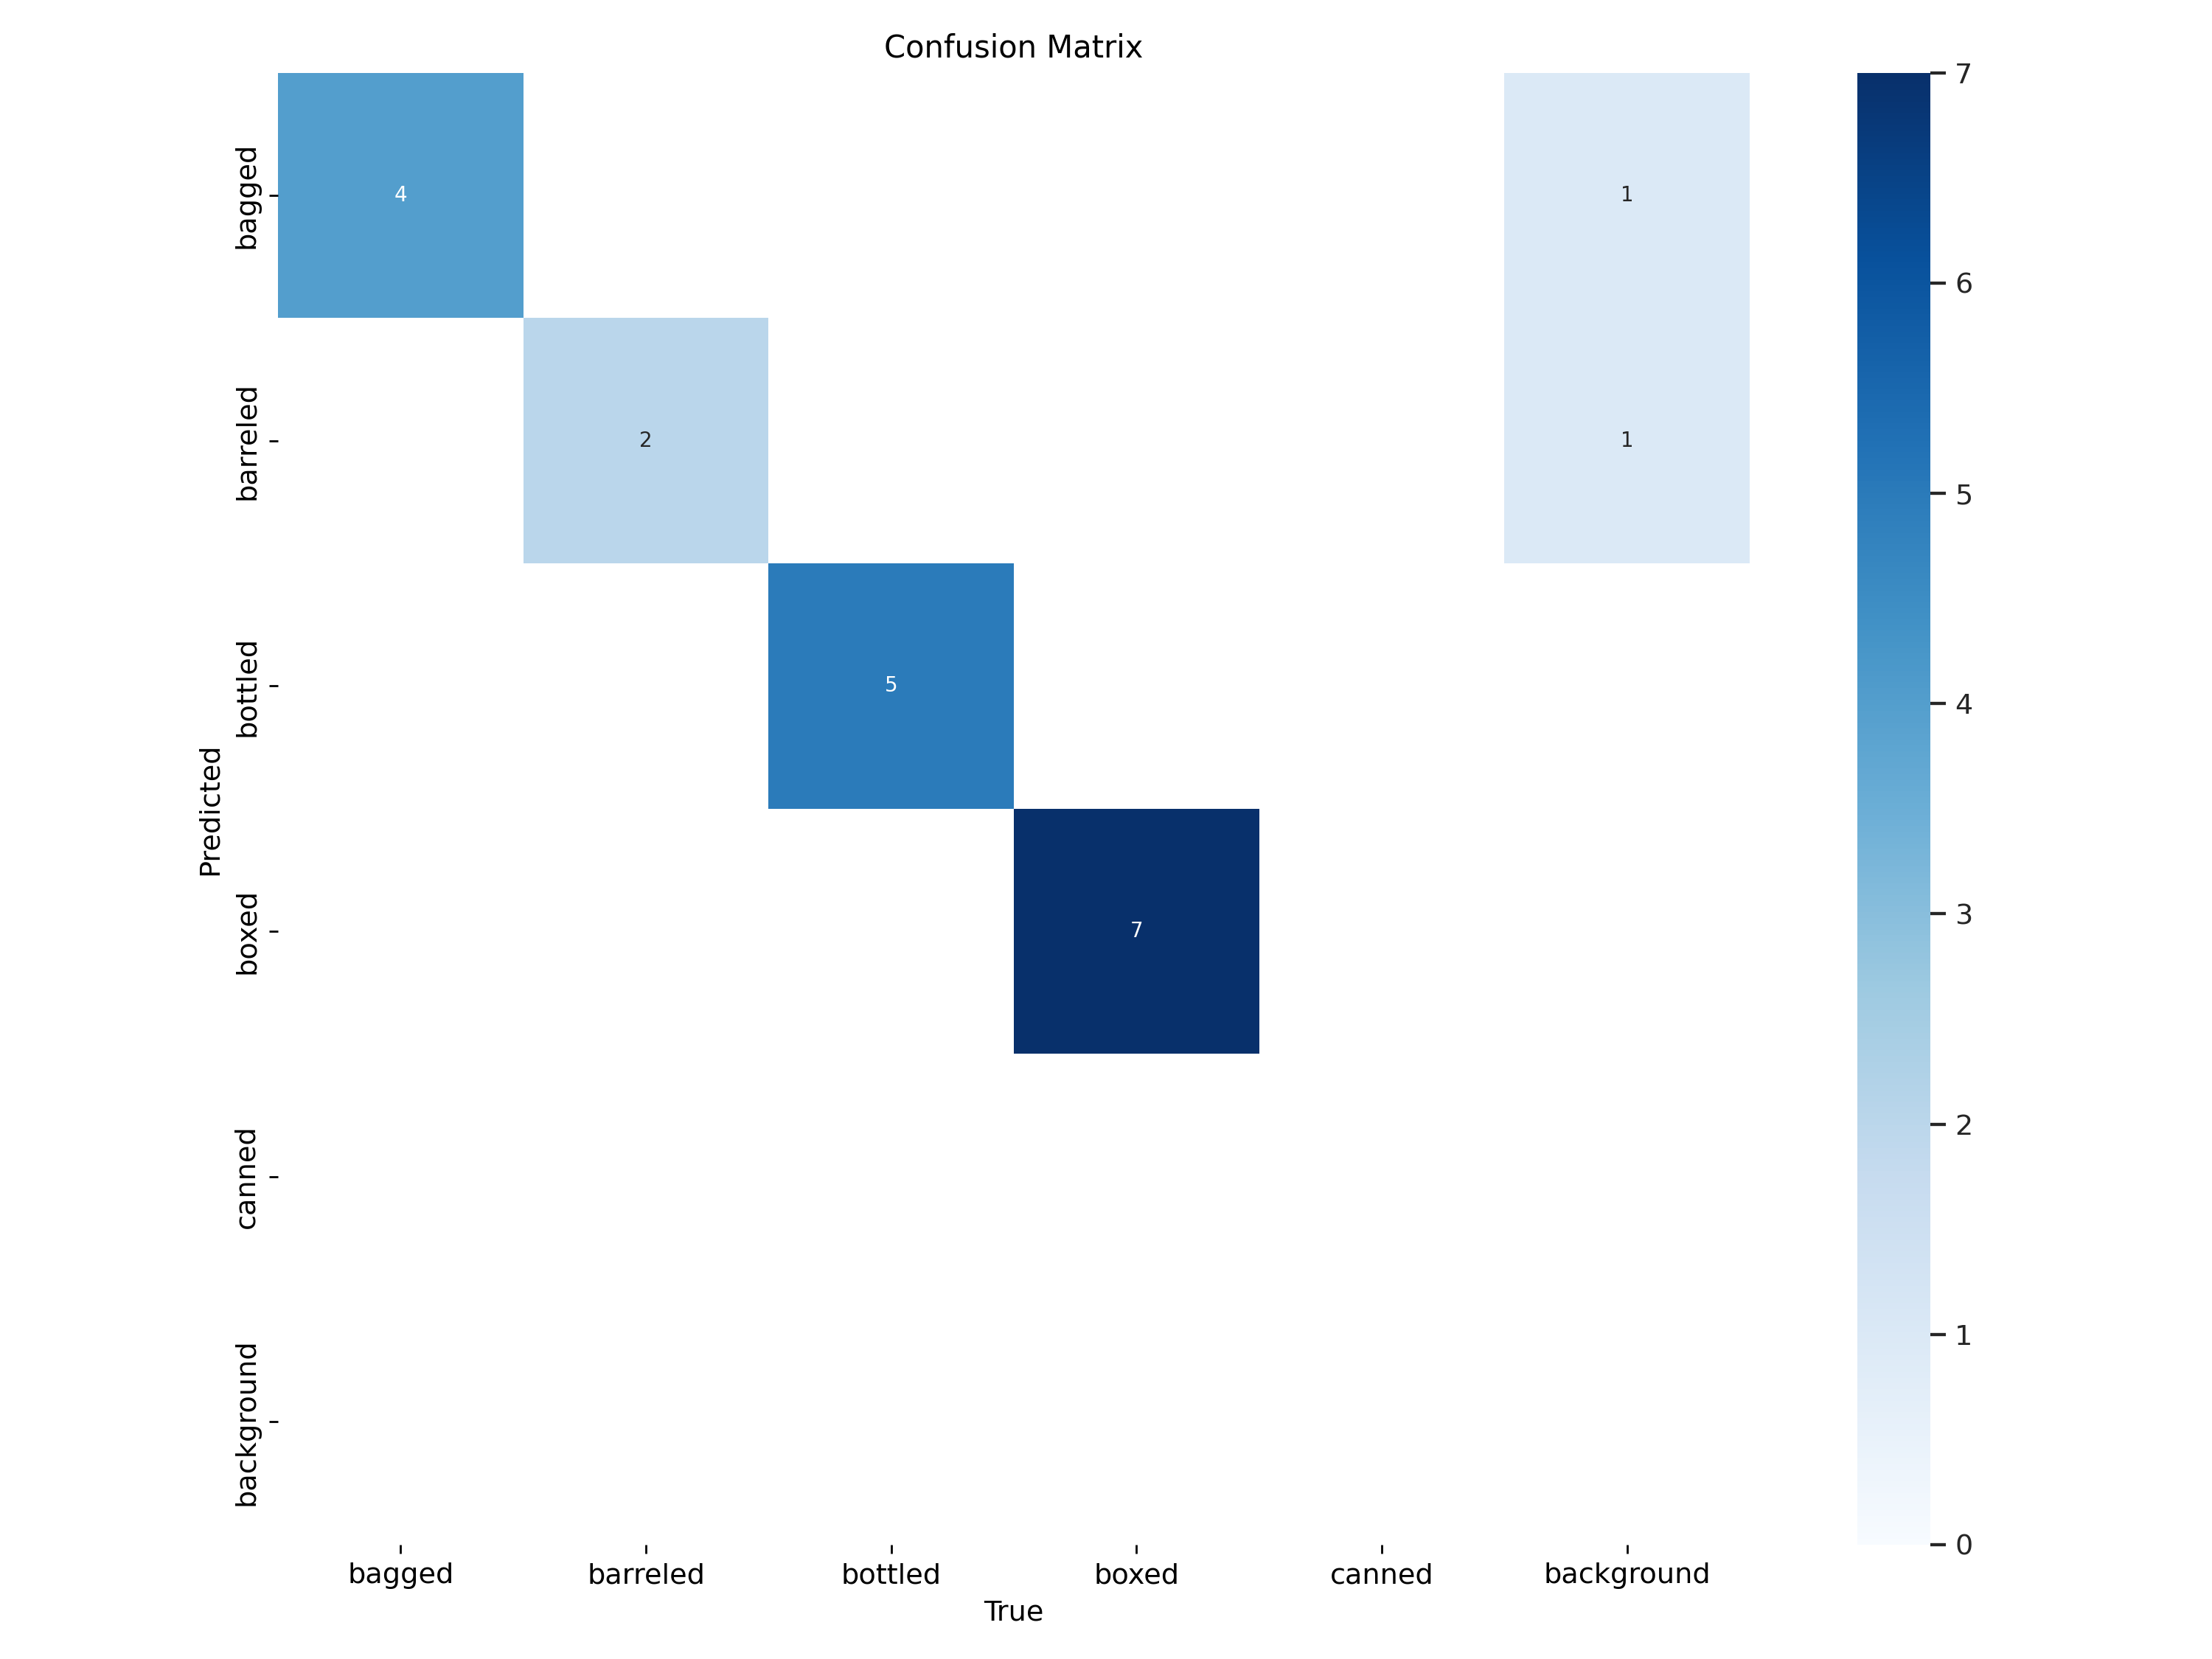

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/segment/train2/confusion_matrix.png', width=1000)

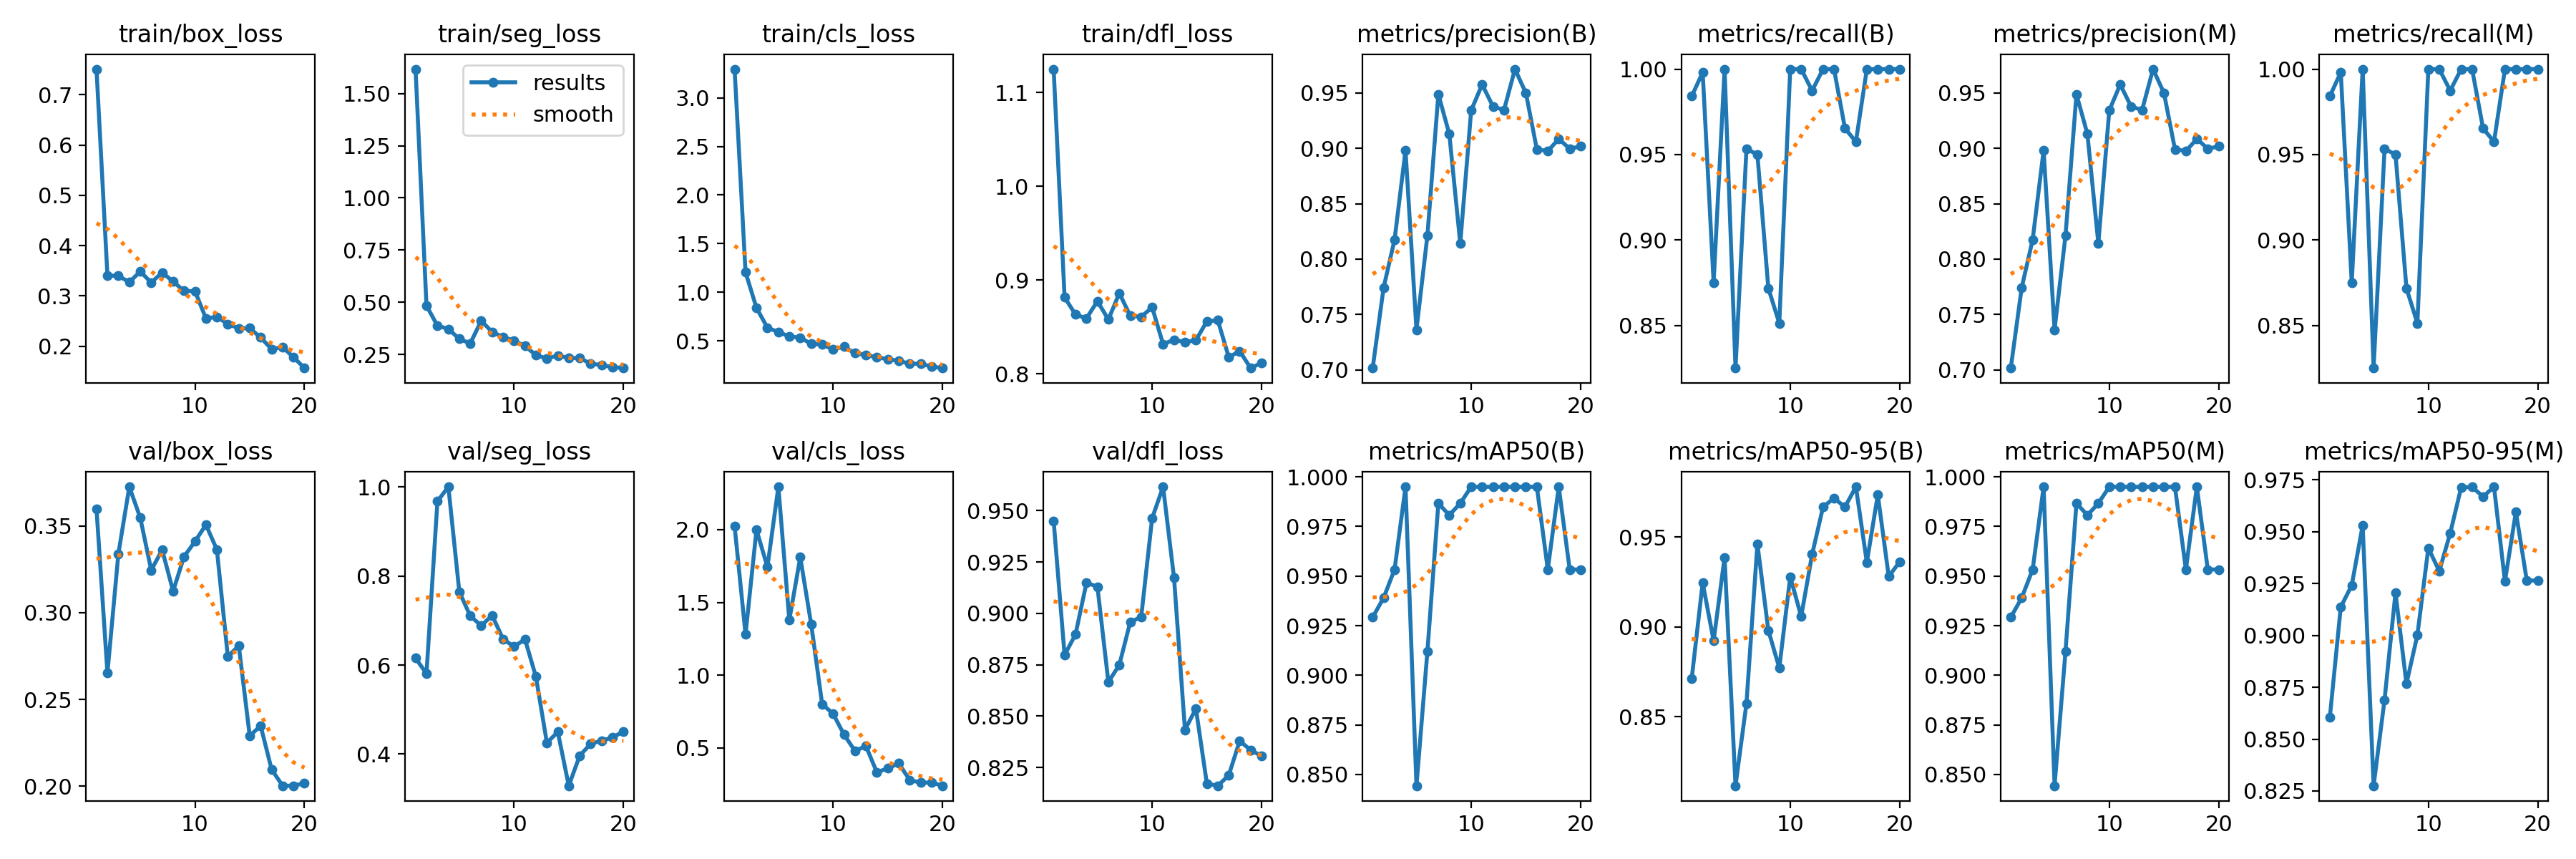

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/segment/train2/results.png', width=1000)

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/train/images",
    annotations_directory_path=f"{dataset_location}/train/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

ds.classes

['bagged', 'barreled', 'bottled', 'boxed', 'canned']

In [ ]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/segment/train2/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [ ]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.9707397384770508
mAP 50 0.9999999999999998
mAP 75 0.9999999999999998


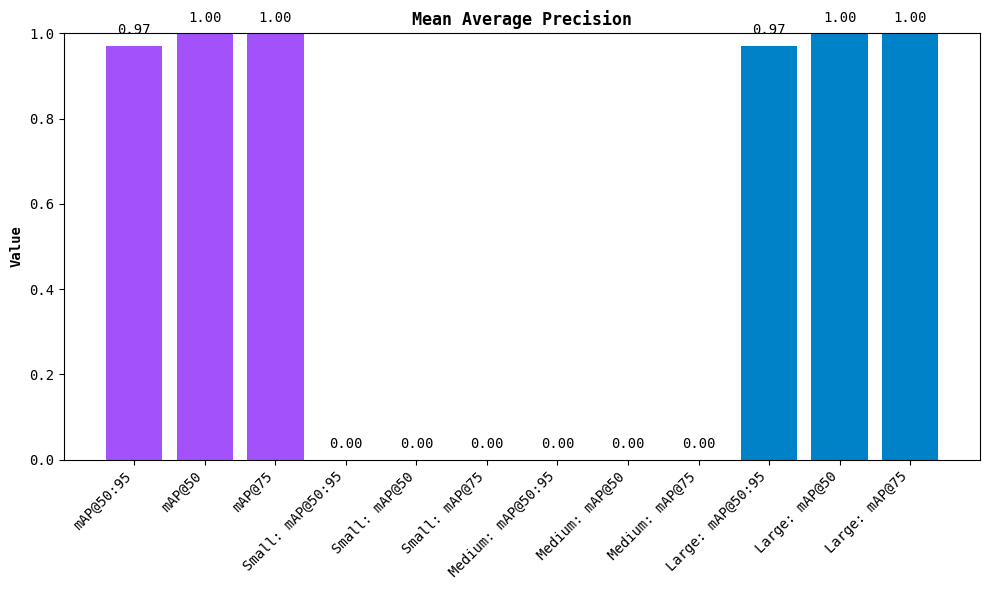

In [ ]:
map.plot()

## Проведите инференс с помощью точно настроенной модели YOLOv8-seg.

In [ ]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/segment/train2/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/train/images",
    annotations_directory_path=f"{dataset_location}/train/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

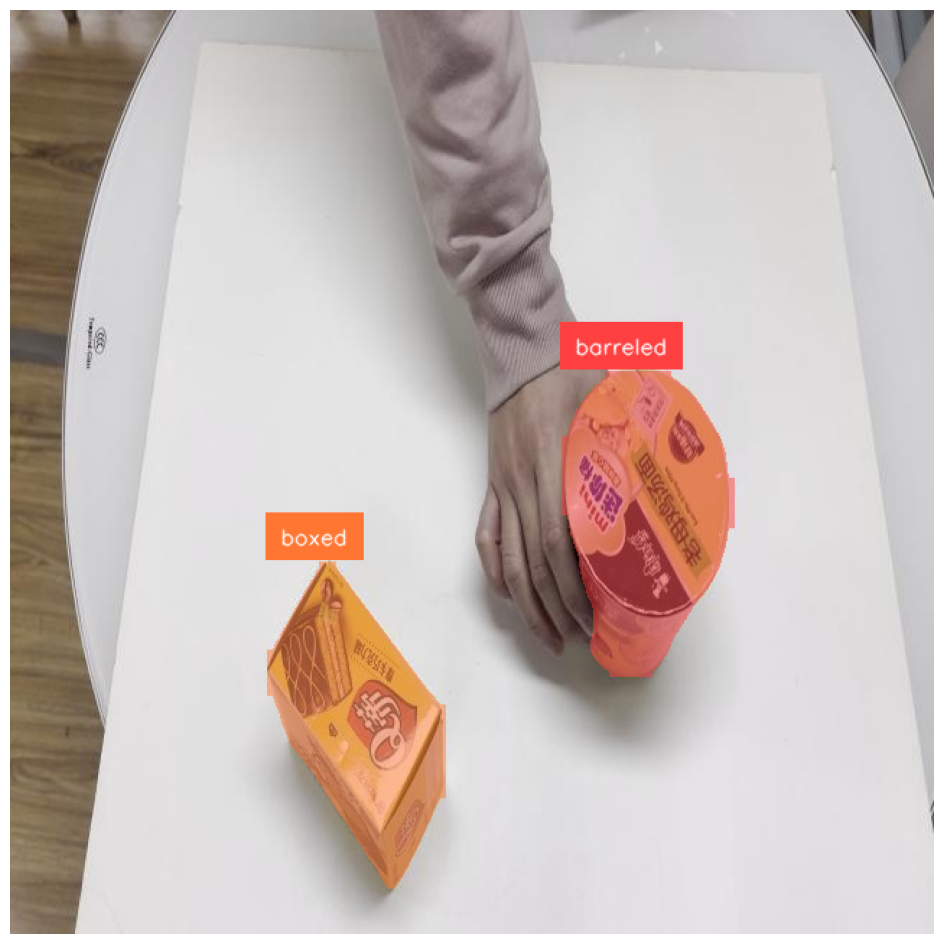

In [ ]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

mask_annotator = sv.MaskAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = mask_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

##Задание подготовить свой датасет, разметить его и обучить модели детекции объектов (все версии yolov8-seg), а также сравнить их по скорости и точности

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.

=== Обучение модели nano (yolov8n-seg) ===


100%|██████████| 6.74M/6.74M [00:00<00:00, 81.6MB/s]


New https://pypi.org/project/ultralytics/8.3.121 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/datasets/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n-seg_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=F

100%|██████████| 755k/755k [00:00<00:00, 14.2MB/s]


Overriding model.yaml nc=80 with nc=16

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.26M/5.26M [00:00<00:00, 63.9MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/train/labels... 503 images, 0 backgrounds, 0 corrupt: 100%|██████████| 503/503 [00:00<00:00, 1451.36it/s]

train: New cache created: /content/datasets/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/valid/labels... 160 images, 1 backgrounds, 0 corrupt: 100%|██████████| 160/160 [00:00<00:00, 778.75it/s]

val: New cache created: /content/datasets/valid/labels.cache


Plotting labels to runs/segment/yolov8n-seg_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0005, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/yolov8n-seg_train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      3.35G      1.083      3.355      3.918      1.331         93        640: 100%|██████████| 32/32 [00:25<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]

                   all        160       1071     0.0361      0.231     0.0918     0.0643     0.0292      0.176     0.0498     0.0327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.13G     0.9977      2.561      3.068      1.256         53        640: 100%|██████████| 32/32 [00:19<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]

                   all        160       1071      0.813      0.109      0.214      0.139      0.764     0.0976      0.168      0.104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.15G     0.9898       2.39      2.512      1.245        106        640: 100%|██████████| 32/32 [00:17<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

                   all        160       1071       0.63      0.219      0.322      0.209      0.542      0.185      0.271      0.167



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.21G      0.964       2.26      2.208      1.228         91        640: 100%|██████████| 32/32 [00:17<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

                   all        160       1071      0.502      0.387      0.395      0.261      0.463      0.351      0.338      0.216



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.38G     0.9358      2.174      2.032      1.229         67        640: 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]

                   all        160       1071       0.52      0.477       0.46      0.312      0.484       0.45      0.417      0.267



5 epochs completed in 0.036 hours.
Optimizer stripped from runs/segment/yolov8n-seg_train/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/yolov8n-seg_train/weights/best.pt, 6.8MB

Validating runs/segment/yolov8n-seg_train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,261,184 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:08<00:00,  1.62s/it]


                   all        160       1071       0.52      0.477      0.459      0.312      0.484      0.449      0.416      0.267
                  boot         37         41      0.896      0.171      0.394      0.213      0.636      0.122      0.302      0.167
                   car        142        145       0.75      0.979      0.942      0.736      0.369      0.483      0.263     0.0848
                  door         50         52      0.556      0.481      0.555      0.327       0.62      0.558      0.681      0.381
          front_bumper         31         31      0.211      0.285      0.216      0.131      0.213      0.288      0.216      0.124
           front_grill         50         52       0.36      0.346      0.287      0.224       0.35      0.346      0.283      0.211
      front_windshield         55         57      0.354      0.895      0.719      0.559      0.353      0.895      0.719      0.592
              headlamp         78        121      0.408      0.628   

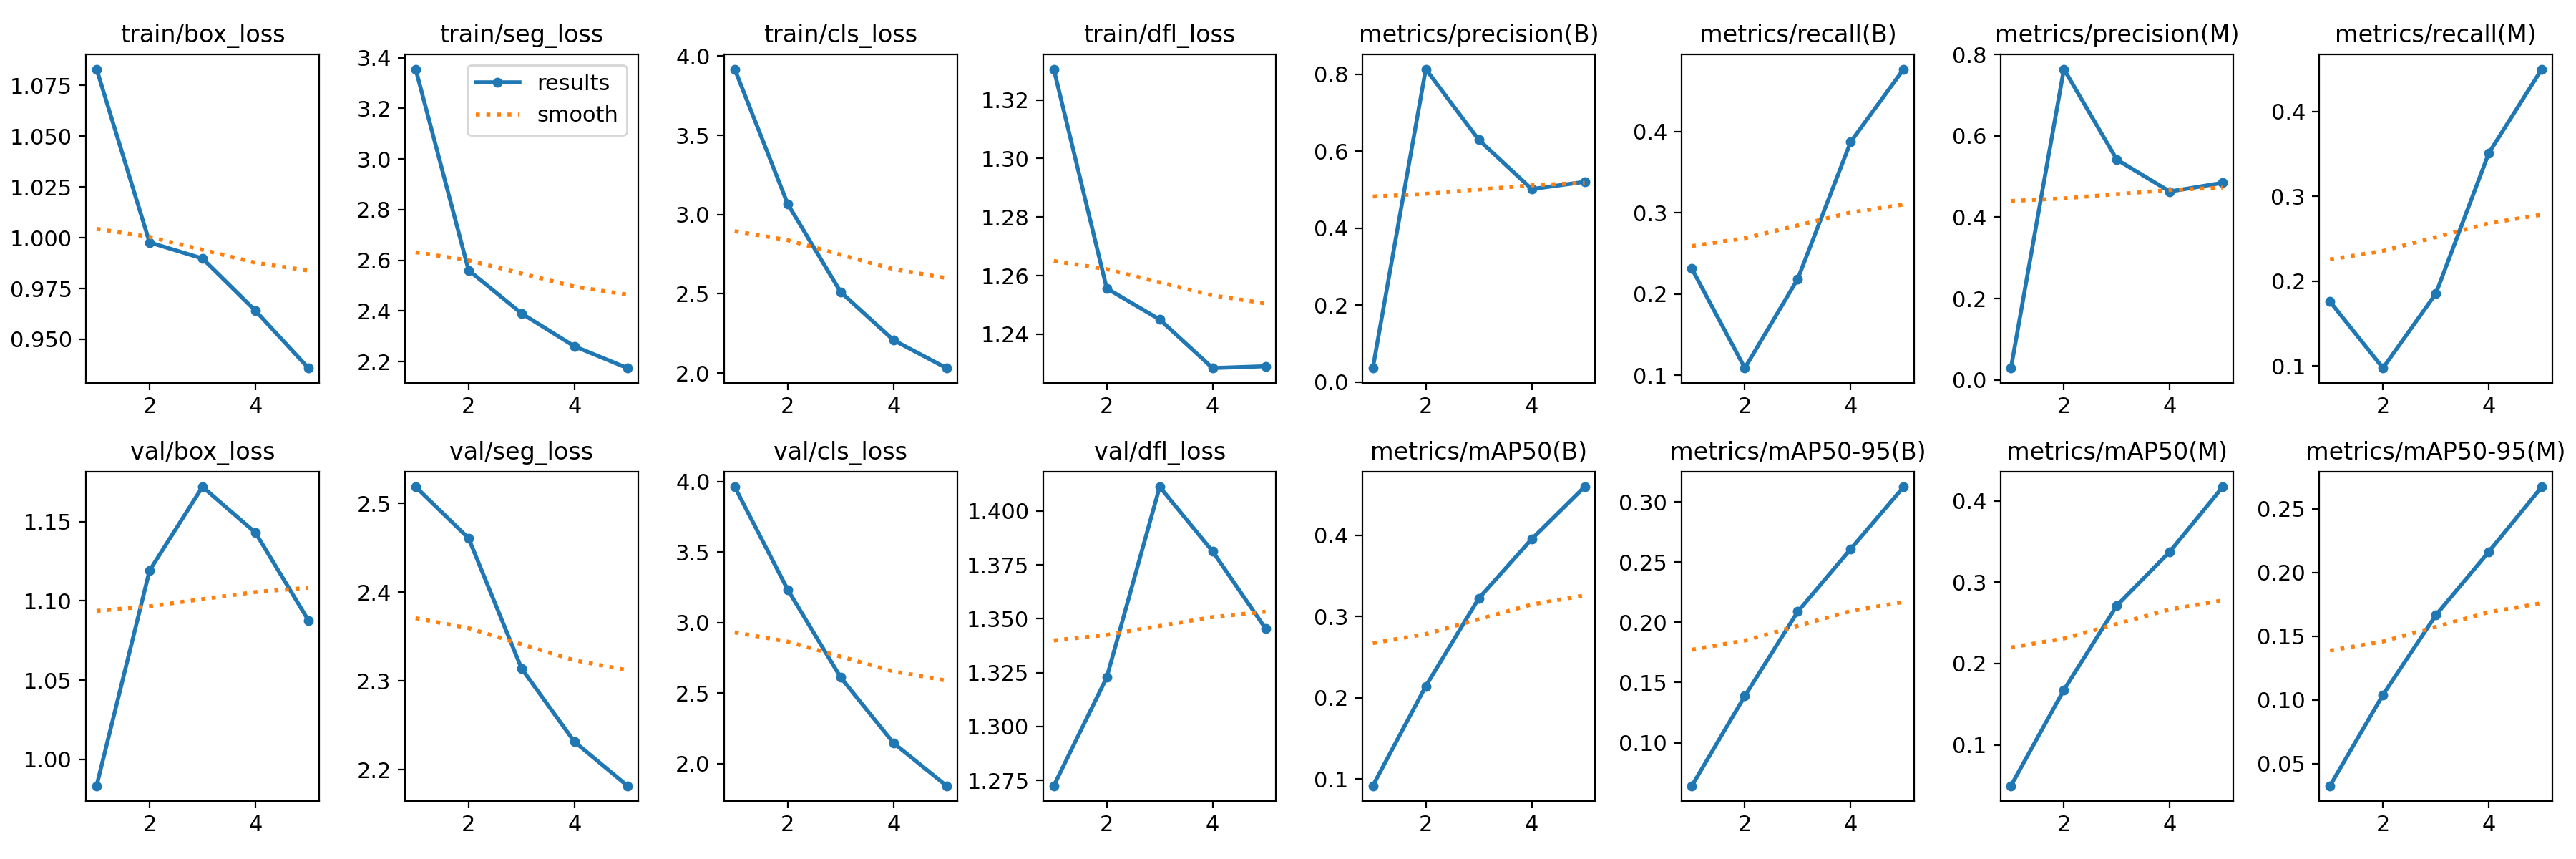


Результаты для nano:
mAP 50:95: 0.2306
mAP 50: 0.3100
mAP 75: 0.2682
Среднее время инференса: 24.43 мс
Количество параметров: 3,261,184
Размер модели: 12.44 MB

=== Обучение модели small (yolov8s-seg) ===


100%|██████████| 22.8M/22.8M [00:00<00:00, 160MB/s] 


New https://pypi.org/project/ultralytics/8.3.121 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=/content/datasets/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s-seg_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=F

train: Scanning /content/datasets/train/labels.cache... 503 images, 0 backgrounds, 0 corrupt: 100%|██████████| 503/503 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/valid/labels.cache... 160 images, 1 backgrounds, 0 corrupt: 100%|██████████| 160/160 [00:00<?, ?it/s]


Plotting labels to runs/segment/yolov8s-seg_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0005, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/yolov8s-seg_train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       5.2G      1.117      3.292       3.25      1.375         93        640: 100%|██████████| 32/32 [00:26<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  80%|████████  | 4/5 [00:11<00:02,  2.91s/it]

Ошибка при работе с моделью small: ERROR ❌ segment dataset incorrectly formatted or not a segment dataset.
This error can occur when incorrectly training a 'segment' model on a 'detect' dataset, i.e. 'yolo train model=yolov8n-seg.pt data=coco8.yaml'.
Verify your dataset is a correctly formatted 'segment' dataset using 'data=coco8-seg.yaml' as an example.
See https://docs.ultralytics.com/datasets/segment/ for help.

=== Итоговое сравнение моделей ===


,map50_95,map50,map75,avg_inference_time_ms,params,size_mb
nano,0.230552,0.309991,0.268248,24.427483,3261184,12.44043


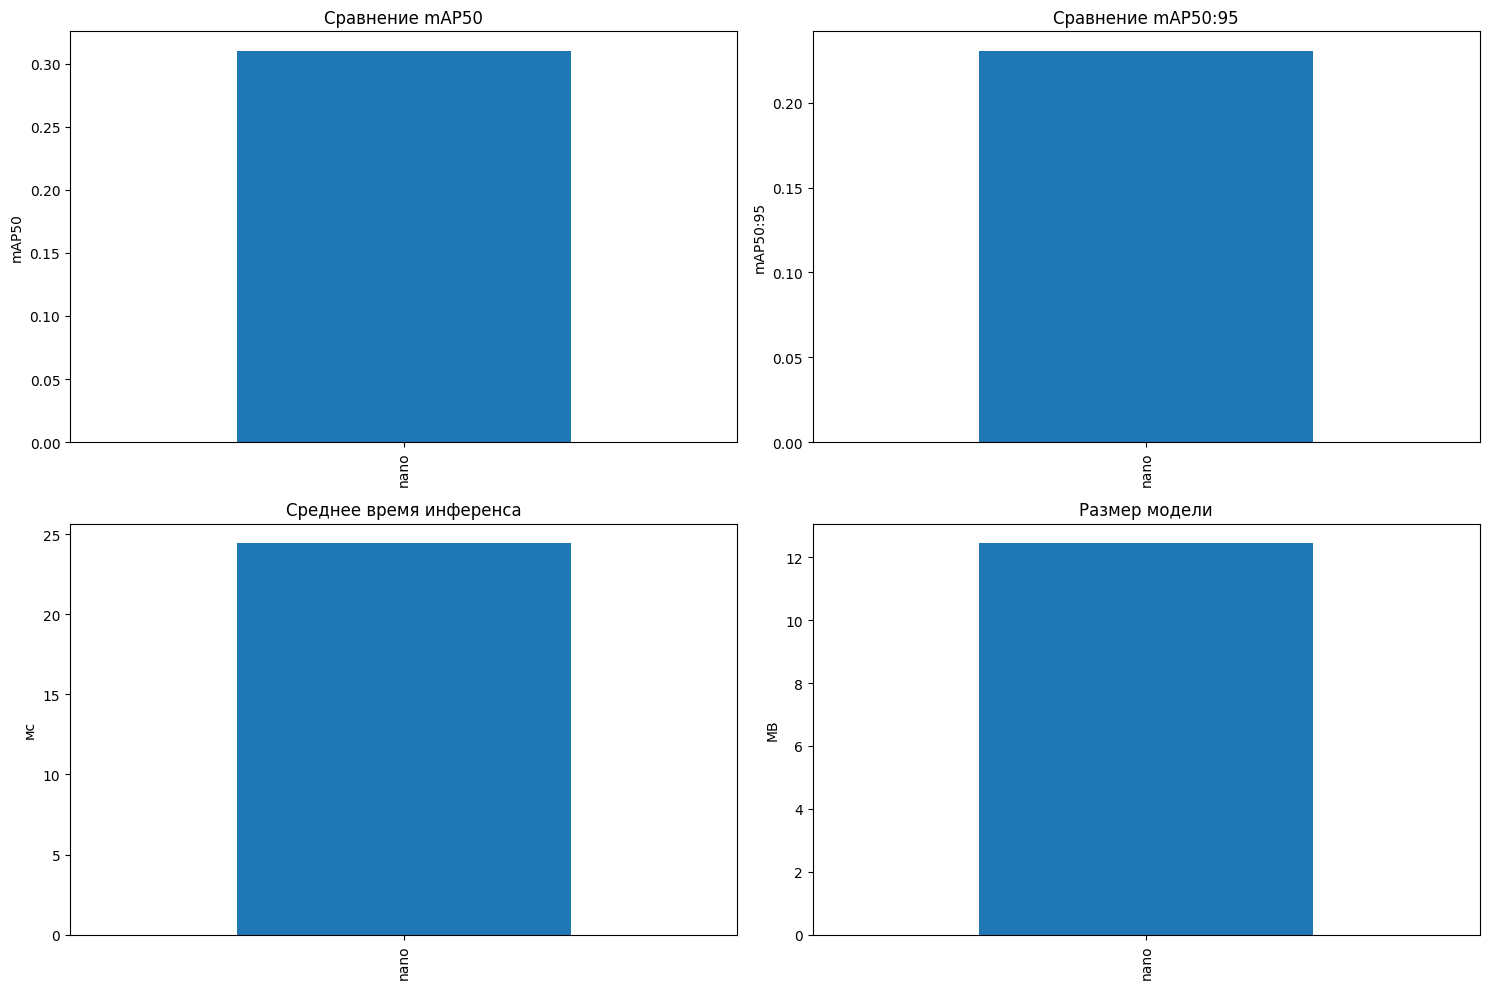

In [ ]:
from ultralytics import YOLO
import supervision as sv
import time
import locale
from IPython.display import Image, display
import pandas as pd
import matplotlib.pyplot as plt

# Установка локали (если есть проблемы с кодировкой)
locale.getpreferredencoding = lambda: "UTF-8"

# Список доступных версий YOLOv8-seg
models = [
    ('yolov8n-seg', 'nano'),
    ('yolov8s-seg', 'small'),
]

results = {}

# Загружаем датасет для оценки
ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/train/images",
    annotations_directory_path=f"{dataset_location}/train/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

# Функция для обучения модели
def train_model(model_name, model_label):
    print(f"\n=== Обучение модели {model_label} ({model_name}) ===")
    model = YOLO(f'{model_name}.pt')
    model.train(
        data=f'{dataset_location}/data.yaml',
        epochs=5,
        imgsz=640,
        batch=16,
        name=f'{model_name}_train'
    )
    return model

# Функция для оценки модели
def evaluate_model(model, model_label, ds):
    print(f"\n=== Оценка модели {model_label} ===")
    predictions = []
    targets = []
    inference_times = []

    for _, image, target in ds:
        start_time = time.time()
        results = model(image, verbose=False)[0]
        inference_times.append(time.time() - start_time)

        detections = sv.Detections.from_ultralytics(results)
        predictions.append(detections)
        targets.append(target)

    map_metrics = sv.metrics.MeanAveragePrecision().update(predictions, targets).compute()
    avg_inference_time = sum(inference_times) / len(inference_times) * 1000  # в миллисекундах

    return {
        'map50_95': map_metrics.map50_95,
        'map50': map_metrics.map50,
        'map75': map_metrics.map75,
        'avg_inference_time_ms': avg_inference_time,
        'params': sum(p.numel() for p in model.model.parameters()),
        'size_mb': sum(p.numel() * p.element_size() for p in model.model.parameters()) / (1024 ** 2)
    }

# Обучаем и оцениваем все модели
for model_name, model_label in models:
    try:
        # Обучение
        model = train_model(model_name, model_label)

        # Оценка
        metrics = evaluate_model(model, model_label, ds)
        results[model_label] = metrics

        # Показываем результаты обучения
        try:
            display(Image(filename=f'{HOME}/runs/segment/{model_name}_train/results.png', width=1000))
        except:
            print("Не удалось загрузить график обучения")

        # Выводим метрики
        print(f"\nРезультаты для {model_label}:")
        print(f"mAP 50:95: {metrics['map50_95']:.4f}")
        print(f"mAP 50: {metrics['map50']:.4f}")
        print(f"mAP 75: {metrics['map75']:.4f}")
        print(f"Среднее время инференса: {metrics['avg_inference_time_ms']:.2f} мс")
        print(f"Количество параметров: {metrics['params']:,}")
        print(f"Размер модели: {metrics['size_mb']:.2f} MB")

    except Exception as e:
        print(f"Ошибка при работе с моделью {model_label}: {str(e)}")

# Создаем таблицу сравнения
if results:
    df = pd.DataFrame.from_dict(results, orient='index')
    print("\n=== Итоговое сравнение моделей ===")
    display(df)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    df['map50'].plot(kind='bar')
    plt.title('Сравнение mAP50')
    plt.ylabel('mAP50')

    plt.subplot(2, 2, 2)
    df['map50_95'].plot(kind='bar')
    plt.title('Сравнение mAP50:95')
    plt.ylabel('mAP50:95')


    plt.subplot(2, 2, 3)
    df['avg_inference_time_ms'].plot(kind='bar')
    plt.title('Среднее время инференса')
    plt.ylabel('мс')


    plt.subplot(2, 2, 4)
    df['size_mb'].plot(kind='bar')
    plt.title('Размер модели')
    plt.ylabel('MB')

    plt.tight_layout()
    plt.show()
else:
    print("Не удалось получить результаты для ни одной модели")

In [ ]:

from ultralytics import YOLO
import supervision as sv
import time
import locale
from IPython.display import Image, display
import pandas as pd
import matplotlib.pyplot as plt

# Установка локали (если есть проблемы с кодировкой)
locale.getpreferredencoding = lambda: "UTF-8"

models = [
    ('yolov8l-seg', 'large'),
    ('yolov8x-seg', 'xlarge')
]

results = {}


ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/train/images",
    annotations_directory_path=f"{dataset_location}/train/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)


def train_model(model_name, model_label):
    print(f"\n=== Обучение модели {model_label} ({model_name}) ===")
    model = YOLO(f'{model_name}.pt')
    model.train(
        data=f'{dataset_location}/data.yaml',
        epochs=5,
        imgsz=640,
        batch=16,
        name=f'{model_name}_train'
    )
    return model


def evaluate_model(model, model_label, ds):
    print(f"\n=== Оценка модели {model_label} ===")
    predictions = []
    targets = []
    inference_times = []

    for _, image, target in ds:
        start_time = time.time()
        results = model(image, verbose=False)[0]
        inference_times.append(time.time() - start_time)

        detections = sv.Detections.from_ultralytics(results)
        predictions.append(detections)
        targets.append(target)

    map_metrics = sv.metrics.MeanAveragePrecision().update(predictions, targets).compute()
    avg_inference_time = sum(inference_times) / len(inference_times) * 1000

    return {
        'map50_95': map_metrics.map50_95,
        'map50': map_metrics.map50,
        'map75': map_metrics.map75,
        'avg_inference_time_ms': avg_inference_time,
        'params': sum(p.numel() for p in model.model.parameters()),
        'size_mb': sum(p.numel() * p.element_size() for p in model.model.parameters()) / (1024 ** 2)
    }


for model_name, model_label in models:
    try:

        model = train_model(model_name, model_label)


        metrics = evaluate_model(model, model_label, ds)
        results[model_label] = metrics


        try:
            display(Image(filename=f'{HOME}/runs/segment/{model_name}_train/results.png', width=1000))
        except:
            print("Не удалось загрузить график обучения")

        # Выводим метрики
        print(f"\nРезультаты для {model_label}:")
        print(f"mAP 50:95: {metrics['map50_95']:.4f}")
        print(f"mAP 50: {metrics['map50']:.4f}")
        print(f"mAP 75: {metrics['map75']:.4f}")
        print(f"Среднее время инференса: {metrics['avg_inference_time_ms']:.2f} мс")
        print(f"Количество параметров: {metrics['params']:,}")
        print(f"Размер модели: {metrics['size_mb']:.2f} MB")

    except Exception as e:
        print(f"Ошибка при работе с моделью {model_label}: {str(e)}")


if results:
    df = pd.DataFrame.from_dict(results, orient='index')
    print("\n=== Итоговое сравнение моделей ===")
    display(df)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    df['map50'].plot(kind='bar')
    plt.title('Сравнение mAP50')
    plt.ylabel('mAP50')

    plt.subplot(2, 2, 2)
    df['map50_95'].plot(kind='bar')
    plt.title('Сравнение mAP50:95')
    plt.ylabel('mAP50:95')


    plt.subplot(2, 2, 3)
    df['avg_inference_time_ms'].plot(kind='bar')
    plt.title('Среднее время инференса')
    plt.ylabel('мс')


    plt.subplot(2, 2, 4)
    df['size_mb'].plot(kind='bar')
    plt.title('Размер модели')
    plt.ylabel('MB')

    plt.tight_layout()
    plt.show()
else:
    print("Не удалось получить результаты для ни одной модели")

FlashAttention is not available on this device. Using scaled_dot_product_attention instead.

=== Обучение модели large (yolov8l-seg) ===


100%|██████████| 88.1M/88.1M [00:01<00:00, 85.8MB/s]


New https://pypi.org/project/ultralytics/8.3.121 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolov8l-seg.pt, data=/content/datasets/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8l-seg_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=F

train: Scanning /content/datasets/train/labels.cache... 503 images, 0 backgrounds, 0 corrupt: 100%|██████████| 503/503 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/valid/labels.cache... 160 images, 1 backgrounds, 0 corrupt: 100%|██████████| 160/160 [00:00<?, ?it/s]


Plotting labels to runs/segment/yolov8l-seg_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0005, momentum=0.9) with parameter groups 106 weight(decay=0.0), 117 weight(decay=0.0005), 116 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/yolov8l-seg_train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      11.8G     0.9978      2.897      2.625      1.364         93        640: 100%|██████████| 32/32 [00:34<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]

                   all        160       1071      0.412      0.548      0.478      0.334      0.372      0.505      0.426       0.28



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      12.1G     0.8657      2.086      1.401      1.226         53        640: 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]

                   all        160       1071      0.533      0.631       0.59      0.391      0.513      0.586      0.547      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      12.1G     0.8354      1.934      1.217      1.194        106        640: 100%|██████████| 32/32 [00:33<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        160       1071      0.553      0.536      0.539       0.37      0.497      0.505      0.483       0.31



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      12.5G      0.789      1.782      1.047      1.161         91        640: 100%|██████████| 32/32 [00:34<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]

                   all        160       1071      0.609       0.61      0.616      0.421      0.577      0.576      0.567      0.369



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      12.6G     0.7309       1.67     0.9513      1.132         67        640: 100%|██████████| 32/32 [00:33<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]

                   all        160       1071      0.684       0.66      0.695      0.495      0.656      0.628      0.653      0.449



5 epochs completed in 0.065 hours.
Optimizer stripped from runs/segment/yolov8l-seg_train/weights/last.pt, 92.3MB
Optimizer stripped from runs/segment/yolov8l-seg_train/weights/best.pt, 92.3MB

Validating runs/segment/yolov8l-seg_train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8l-seg summary (fused): 295 layers, 45,924,224 parameters, 0 gradients, 220.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


                   all        160       1071      0.684       0.66      0.695      0.496      0.656      0.628      0.653      0.449
                  boot         37         41      0.546      0.537      0.548      0.398      0.545      0.537      0.546      0.366
                   car        142        145      0.874      0.979       0.94      0.845      0.468      0.524      0.334      0.138
                  door         50         52      0.902      0.673      0.765      0.537      0.926      0.692      0.798      0.573
          front_bumper         31         31      0.219      0.387      0.296      0.161      0.199      0.355      0.267      0.141
           front_grill         50         52      0.566      0.615      0.616      0.442      0.566      0.615      0.608      0.442
      front_windshield         55         57      0.535       0.86      0.844      0.675      0.533       0.86      0.844      0.713
              headlamp         78        121       0.73      0.752   